# Computational Graphs - Signed Distance Functions and Particle Physics
*Christoph Heindl 2017, https://github.com/cheind/py-cgraph/*

This is part four in series about computational graphs and their applications. In the first two parts the fundamental concepts of symbolic computation and especially automatic derivative calculus were covered. 

This part introduces signed distance functions and applies them in the context of particle physics. As we will see, signed distance functions provide an algebraic way to quickly model environments that can be used for efficient collision tests and responses.

As always Python 3.x knowledge is assumed. I'm also assuming familiarity with physical based animations. If you need a head start on particle physics you might want to get a copy of 'Foundations of Physically based Modeling & Animation'. Before we dive in, here's a preview of what we will end up with (click the image to view on Youtube, or scroll down to view in notebook).

[![](images/particle_physics.gif)](https://www.youtube.com/watch?v=N_R7vjEWFWs])

## Signed Distance Functions

[Signed distance functions][1] (SDF) are functions that map from spatial locations to surface distances. Given a location in Euclidean space the signed distance function will respond with distance to the closest surface. *Signed* comes from the fact that surfaces define outside and inside relations. We will use the convention that negative distance values are associated with locations inside of surfaces and positive values correspond to region outside of any surface. While signed distance functions work in any spatial dimensions, we will restrict ourself to two dimensions.

Beside distance queries, signed distance functions also offer another useful property: the gradient, that is the derivative with respect to the spatial coordinates, forms a vector that points in the direction of fastest distance ascent.

We will be using distance queries to detect particle-environment collisions and gradient information to collision responses.

## Signed Distance Function in Python using CGraph

Since signed distance functions are ordinary functions we can express them symbolically in Python using CGraph as we've seen before for other functions. Here's how we will go about it. First, we will define so called leaf nodes or primitives, such as circles and half-spaces. These primitives are building blocks for more complex environments to be modelled with SDF. Next, we will define operations on primitives that will allow us to join primitives, slowly allowing us to build more and more complex SDFs.

[1]: https://en.wikipedia.org/wiki/Signed_distance_function

In [1]:
import sys
sys.path.append('..')
import cgraph as cg
import numpy as np
np.seterr(all='ignore');

First, we define a function that generates a set of noisy points along an ideal line parametrized by $y = w_0*x+w_1$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def generate_points(n, k, d):
    x = np.linspace(0, 10, n)
    y = x * k + d + np.random.normal(scale=0.15, size=n)
    return np.vstack((x,y))

# Parameters of ideal line
k = 0.8
d = 2.0

samples = generate_points(20, k, d)

Let's plot the samples

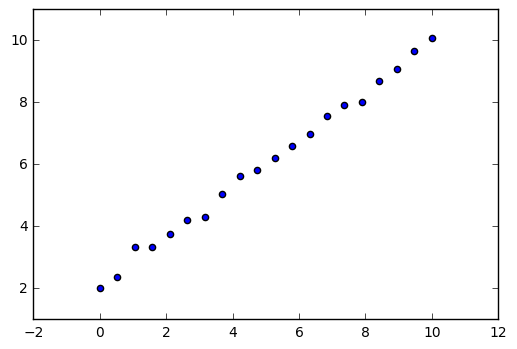

In [3]:
plt.scatter(samples[0,:], samples[1,:])
plt.show()

Next, we define the objective function to be minimized

$$f(w_0,w_1;x_0..x_n, y_0..y_n) = \sum_i^n{(w_0*x_i + w_1 - y_i)^2}$$

with respect to the unknown parameters $w_0$ and $w_1$.

We are searching for a minimum of the sum of squared residuals between a line parametrized by $w_0$, $w_1$ and the samples given. Note that the error is measured along the y-axis (called the algebraic distance). In case you are interested see [ordinary-least-squares](https://en.wikipedia.org/wiki/Ordinary_least_squares).

It is straight forward to represent $f$ in `CGraph`

In [4]:
def sum_residuals_squared(w0, w1, xy):
    n = xy.shape[1]
    residuals = []
    for i in range(n):
        r = w0 * xy[0,i] + w1 - xy[1,i]
        residuals.append(r**2)

    return cg.sym_sum(residuals) / n

w0 = cg.Symbol('w0')
w1 = cg.Symbol('w1')

f = sum_residuals_squared(w0, w1, samples)

Note the `/n` is a normalizing constant. It is optional and does not the change the minimum. Its purpose is to make the gradient lengths independent of the number of point samples used.

The expression tree associated with `f` is given by

In [5]:
f

(((((w0*[ 0.]) + w1) - [ 2.0154619])**[2] + (((w0*[ 0.52631579]) + w1) - [ 2.36365838])**[2] + (((w0*[ 1.05263158]) + w1) - [ 3.32633244])**[2] + (((w0*[ 1.57894737]) + w1) - [ 3.34190964])**[2] + (((w0*[ 2.10526316]) + w1) - [ 3.74844096])**[2] + (((w0*[ 2.63157895]) + w1) - [ 4.21462809])**[2] + (((w0*[ 3.15789474]) + w1) - [ 4.29121587])**[2] + (((w0*[ 3.68421053]) + w1) - [ 5.05847613])**[2] + (((w0*[ 4.21052632]) + w1) - [ 5.62812847])**[2] + (((w0*[ 4.73684211]) + w1) - [ 5.83253967])**[2] + (((w0*[ 5.26315789]) + w1) - [ 6.22003314])**[2] + (((w0*[ 5.78947368]) + w1) - [ 6.58010538])**[2] + (((w0*[ 6.31578947]) + w1) - [ 6.97864537])**[2] + (((w0*[ 6.84210526]) + w1) - [ 7.57425979])**[2] + (((w0*[ 7.36842105]) + w1) - [ 7.92074757])**[2] + (((w0*[ 7.89473684]) + w1) - [ 8.02516006])**[2] + (((w0*[ 8.42105263]) + w1) - [ 8.68286489])**[2] + (((w0*[ 8.94736842]) + w1) - [ 9.07390932])**[2] + (((w0*[ 9.47368421]) + w1) - [ 9.6737661])**[2] + (((w0*[ 10.]) + w1) - [ 10.06550887])**

What's given below is the reference implementation of an ordinary least squares regression. We will be using this as a reference for comparison with other implementations.

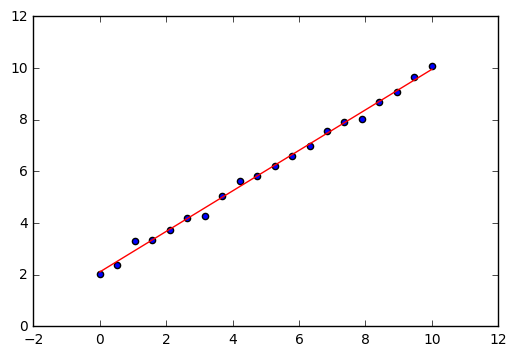

In [6]:
def least_squares_fit(xy):
    """Returns the line parameters through ordinary least squares regression."""

    A = np.ones((xy.shape[1], 2))    
    A[:,0] = xy[0,:].T
    b = xy[1,:].T

    return np.dot(np.dot(np.linalg.inv(np.dot(A.T,A)), A.T), b)

s_fit = least_squares_fit(samples)

plt.plot([0, 10], [0*s_fit[0]+s_fit[1], 10*s_fit[0]+s_fit[1]], color='r', linestyle='-', label='Least Squares')
plt.scatter(samples[0,:], samples[1,:])
plt.show()

### Steepest descent

[Steepest descent](https://en.wikipedia.org/wiki/Method_of_steepest_descent) is an iterative optimization method that, given an initial guess, finds a better guess by taking a step in the direction of the negative gradient. Once the norm of the gradient is sufficiently close to zero, one claims to have found a stationary point (local minimum).

This method is of first-order as it requires only first order derivatives. With CGraph it can be implemented in the following way.

In [7]:
def steepest_descent(f, w0, w1, guess, verbose=True):    
    lam = 0.02

    for i in range(200):   
        df = cg.numeric_gradient(f, guess)

        guess[w0] -= lam * df[w0]
        guess[w1] -= lam * df[w1]

    if verbose:
        print('Steepest descent solution {}, {}'.format(guess[w0], guess[w1]))
        print('Error {}'.format(cg.value(f, guess)))

    return guess

In each iteration the method takes a scaled step (by `lam`) in the direction of the negative gradient. Let's see how well it converges.

Steepest descent solution [ 0.80089942], [ 1.99680266]
Error [ 0.02638411]


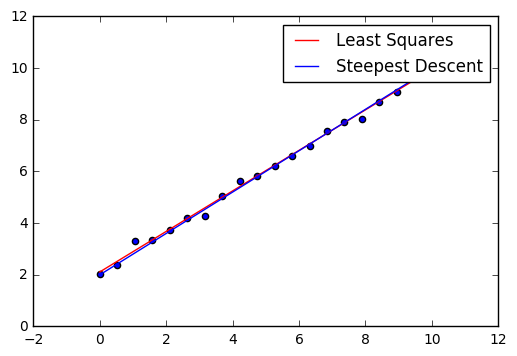

In [8]:
s_sd = steepest_descent(f, w0, w1, {w0: 0.4, w1: 1.1})

plt.plot([0, 10], [0*s_fit[0]+s_fit[1], 10*s_fit[0]+s_fit[1]], color='r', linestyle='-', label='Least Squares')
plt.plot([0, 10], [0*s_sd[w0]+s_sd[w1], 10*s_sd[w0]+s_sd[w1]], color='b', linestyle='-', label='Steepest Descent')
plt.scatter(samples[0,:], samples[1,:])
plt.legend()
plt.show()

Not quite, but also not far off from the reference. Variations of the steepest descent are the tools of the trade to train neural networks.

## Newton's method for function optimization

Next up is [Newton's method](https://en.wikipedia.org/wiki/Newton's_method_in_optimization), which frees us from a fixed step size when descenting. It comes at the cost that we need to compute second order derivatives. Although it is an iterative approach, Newton's method will take just one step for our problem setting. This is due to the fact that our object function has exactly the shape that Newton's method is approximating in each step.

In [9]:
def newton_descent(f, w0, w1, guess, verbose=True, simplify=False):
    d1 = cg.symbolic_gradient(f)        # gives df/dw0, df/dw1
    d2w0 = cg.symbolic_gradient(d1[w0]) # gives ddf/dw0dw0, ddf/dw0dw1,
    d2w1 = cg.symbolic_gradient(d1[w1]) # gives ddf/dw1dw1, ddf/dw1dw0,

    if simplify:
        d2w0 = cg.simplify_all(d2w0)
        d2w1 = cg.simplify_all(d2w1)
    
    def nhessian(guess):
        h = np.zeros((2,2)) 
        h[0,0] = cg.value(d2w0[w0], guess)
        h[0,1] = cg.value(d2w0[w1], guess)
        h[1,0] = cg.value(d2w1[w0], guess) # Hessian is symmetric, could reuse h[0,1]
        h[1,1] = cg.value(d2w1[w1], guess)
        return h

    def ngrad(guess):
        g = np.zeros((2,1))
        g[0, 0] = cg.value(d1[w0], guess)
        g[1, 0] = cg.value(d1[w1], guess)
        return g

    # Single step is enough, since our objective function is of quadric shape.
    step = np.linalg.inv(nhessian(guess)).dot(ngrad(guess))
    guess[w0] -= step[0,0]
    guess[w1] -= step[1,0]

    if verbose:
        print('Newton solution {}, {}'.format(guess[w0], guess[w1]))
        print('Error {}'.format(cg.value(f, guess)))

    return guess

Newton solution 0.784419083547322, 2.108694184738646
Error [ 0.02301286]


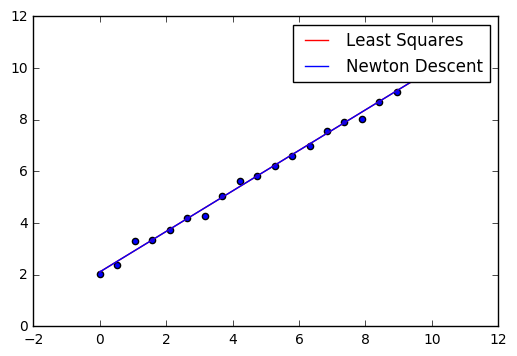

In [10]:
s_sn = newton_descent(f, w0, w1, {w0: 0.4, w1: 1.1})

plt.plot([0, 10], [0*s_fit[0]+s_fit[1], 10*s_fit[0]+s_fit[1]], color='r', linestyle='-', label='Least Squares')
plt.plot([0, 10], [0*s_sn[w0]+s_sn[w1], 10*s_sn[w0]+s_sn[w1]], color='b', linestyle='-', label='Newton Descent')
plt.scatter(samples[0,:], samples[1,:])
plt.legend()
plt.show()

Good match there. What about performance?

In [11]:
%timeit newton_descent(f, w0, w1, {w0: 0.4, w1: 1.1}, verbose=False)

10 loops, best of 3: 30.7 ms per loop


In [12]:
%timeit steepest_descent(f, w0, w1, {w0: 0.4, w1: 1.1}, verbose=False)

1 loop, best of 3: 350 ms per loop


A single step in the Newton descent is much more costly than a single iteration inside the steepest descent method. Newton's method requires us to compute second order derivatives which is computationally more expensive than going with first order derivates. Still Newton's method requires just a single step and thus converges faster than steepest descent.